In [190]:
import numpy as np
import pandas as pd
import glob
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from functools import reduce
import time
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

%matplotlib inline

# Read Files: invocations_per_function_md.anon.d*.csv

In [86]:
# dataset de invocaciones por funcion
ipf_data_path = "azurefunctions-dataset2019/invocations_per_function_md.anon.d*.csv"
ipf_csv_paths = glob.glob(ipf_data_path, recursive=True) # se colocan todos los paths encontrados
ipf_dfs = [pd.read_csv(ipf_csv_path) for ipf_csv_path in ipf_csv_paths] # crear un dataframe a partir de cada path

In [87]:
# filtramos solo las funciones de tipo de trigger (timer)
# luego renombramos columnas
default_columns = ['HashOwner', 'HashApp', 'HashFunction', 'Trigger']
for i, ipf_df in enumerate(ipf_dfs):
    ipf_dfs[i] = ipf_dfs[i][ipf_dfs[i]["Trigger"] == "timer"]
    ipf_dfs[i].columns = default_columns + [time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(x)) for x in range(1563148800+i*86400, 1563148800+(i+1)*86400, 60)]

In [88]:
# hacemos merge de estos dataframes sobre las combinaciones de HashOwner, HashApp y HashFunction que correspondan
ipf_dfs_merged = reduce(lambda  left,right: pd.merge(left,right,on=['HashOwner', 'HashApp', 'HashFunction', 'Trigger'],
                                            how='outer'), ipf_dfs)
ipf_dfs_merged.head()

,HashOwner,HashApp,HashFunction,Trigger,2019-07-15 00:00:00,2019-07-15 00:01:00,2019-07-15 00:02:00,2019-07-15 00:03:00,2019-07-15 00:04:00,2019-07-15 00:05:00,...,2019-07-28 23:50:00,2019-07-28 23:51:00,2019-07-28 23:52:00,2019-07-28 23:53:00,2019-07-28 23:54:00,2019-07-28 23:55:00,2019-07-28 23:56:00,2019-07-28 23:57:00,2019-07-28 23:58:00,2019-07-28 23:59:00
0,71ca12c7af70d021e285b51b245942f8432df6463ff9f2...,a04487a6ba1e14296eb7647e4963180d28bef7a90a8fc5...,0b4453d16b9c62e9562e0242aefb7757a5972a9f7481f0...,timer,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,3bc09e5bba34209e93e552d6fb5e09606d140d7dbae837...,828d25d1ad61b8cca03987240e15fec9f3eefb5ca33ecb...,5e3de8288370ea52d8cb318340279b11127ddaebc19179...,timer,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,98f3fe1d01789fc2d8ab1dc9cd9a31d51fcbf1936e36a4...,fb56807dd94188173df7fcf08d76fb8d93509d86b44f6b...,25f523973257948ea335ca7cf18dc2116e05dd2e6cd61a...,timer,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,98f3fe1d01789fc2d8ab1dc9cd9a31d51fcbf1936e36a4...,fb56807dd94188173df7fcf08d76fb8d93509d86b44f6b...,f1c924b88698471f94f7538130b5a440b2db98e6501546...,timer,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,98f3fe1d01789fc2d8ab1dc9cd9a31d51fcbf1936e36a4...,fb56807dd94188173df7fcf08d76fb8d93509d86b44f6b...,3a3c2c2d8c14dc9c32f9d5d495e09c1e3782fd7550efb1...,timer,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
ipf_dfs_merged.fillna(0)

,HashOwner,HashApp,HashFunction,Trigger,2019-07-15 00:00:00,2019-07-15 00:01:00,2019-07-15 00:02:00,2019-07-15 00:03:00,2019-07-15 00:04:00,2019-07-15 00:05:00,...,2019-07-28 23:50:00,2019-07-28 23:51:00,2019-07-28 23:52:00,2019-07-28 23:53:00,2019-07-28 23:54:00,2019-07-28 23:55:00,2019-07-28 23:56:00,2019-07-28 23:57:00,2019-07-28 23:58:00,2019-07-28 23:59:00
0,71ca12c7af70d021e285b51b245942f8432df6463ff9f2...,a04487a6ba1e14296eb7647e4963180d28bef7a90a8fc5...,0b4453d16b9c62e9562e0242aefb7757a5972a9f7481f0...,timer,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,3bc09e5bba34209e93e552d6fb5e09606d140d7dbae837...,828d25d1ad61b8cca03987240e15fec9f3eefb5ca33ecb...,5e3de8288370ea52d8cb318340279b11127ddaebc19179...,timer,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,98f3fe1d01789fc2d8ab1dc9cd9a31d51fcbf1936e36a4...,fb56807dd94188173df7fcf08d76fb8d93509d86b44f6b...,25f523973257948ea335ca7cf18dc2116e05dd2e6cd61a...,timer,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,98f3fe1d01789fc2d8ab1dc9cd9a31d51fcbf1936e36a4...,fb56807dd94188173df7fcf08d76fb8d93509d86b44f6b...,f1c924b88698471f94f7538130b5a440b2db98e6501546...,timer,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,98f3fe1d01789fc2d8ab1dc9cd9a31d51fcbf1936e36a4...,fb56807dd94188173df7fcf08d76fb8d93509d86b44f6b...,3a3c2c2d8c14dc9c32f9d5d495e09c1e3782fd7550efb1...,timer,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20069,964e15b53c066afb18959b807133aa0d57b77e3d11bc84...,adf98a2aa505153aebafa4c21230f1ebf475bc9504b98f...,ce5d958785a8a3f04651cc04196b751f6451b0fa0126dc...,timer,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20070,31a046cbd320c4e65de6b0c813c792f2e8349c75f62b63...,186822d8d8f99b8bbe2c70d2c8ce06a385375d47790e06...,103a1c75c10b6a0c9dcc47f6c8d9a054b1d725195f3030...,timer,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
20071,d9f44ff0d5b3531a7499c4d355ccaf176bb726abf50e77...,a8f4a36d3a8c0c6c9814db46d795630a648d322389db46...,beeaf2afbcb0026ad4de2daf6712ce37db298299e92c5f...,timer,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20072,76de1380f5c86665ee924a3aa30af9ba275b840469acda...,f5ebadb95c618659bbd16acec164c8a0522c9b7c414cac...,61d6bbf38ef5e35dd6475c44a7ebc1f2f62b234e96aa78...,timer,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Data Global

In [96]:
# obtenemos data global
ipf_dfs_new_merged = ipf_dfs_merged.iloc[:,4:]
ipf_dfs_new_merged.head()

,2019-07-15 00:00:00,2019-07-15 00:01:00,2019-07-15 00:02:00,2019-07-15 00:03:00,2019-07-15 00:04:00,2019-07-15 00:05:00,2019-07-15 00:06:00,2019-07-15 00:07:00,2019-07-15 00:08:00,2019-07-15 00:09:00,...,2019-07-28 23:50:00,2019-07-28 23:51:00,2019-07-28 23:52:00,2019-07-28 23:53:00,2019-07-28 23:54:00,2019-07-28 23:55:00,2019-07-28 23:56:00,2019-07-28 23:57:00,2019-07-28 23:58:00,2019-07-28 23:59:00
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [144]:
# Get sum of all rows in the Dataframe as a Series
ipf_totals = ipf_dfs_new_merged.sum()
ipf_totals.index = pd.to_datetime(ipf_totals.index)
print('Total invocations per minute:')
display(ipf_totals)

Total invocations per minute:


2019-07-15 00:00:00    20384.0
2019-07-15 00:01:00    10234.0
2019-07-15 00:02:00    10711.0
2019-07-15 00:03:00    10660.0
2019-07-15 00:04:00    11115.0
                        ...   
2019-07-28 23:55:00    13156.0
2019-07-28 23:56:00    10590.0
2019-07-28 23:57:00    10189.0
2019-07-28 23:58:00    10378.0
2019-07-28 23:59:00    10047.0
Length: 20160, dtype: float64

In [155]:
ipf_totals.describe().transpose()


count    20160.000000
mean     11305.688988
std       1972.120770
min       8926.000000
25%      10143.000000
50%      10581.000000
75%      11241.000000
max      20743.000000
dtype: float64

In [176]:
ipf_totals_test = ipf_totals.copy()
ipf_totals_test.index = ipf_totals_test.index.time
ipf_totals_test = ipf_totals_test.groupby(level=0).sum()
display(ipf_totals_test)


00:00:00    285868.0
00:01:00    144560.0
00:02:00    151203.0
00:03:00    150509.0
00:04:00    156705.0
              ...   
23:55:00    185445.0
23:56:00    149316.0
23:57:00    143847.0
23:58:00    146995.0
23:59:00    142092.0
Length: 1440, dtype: float64

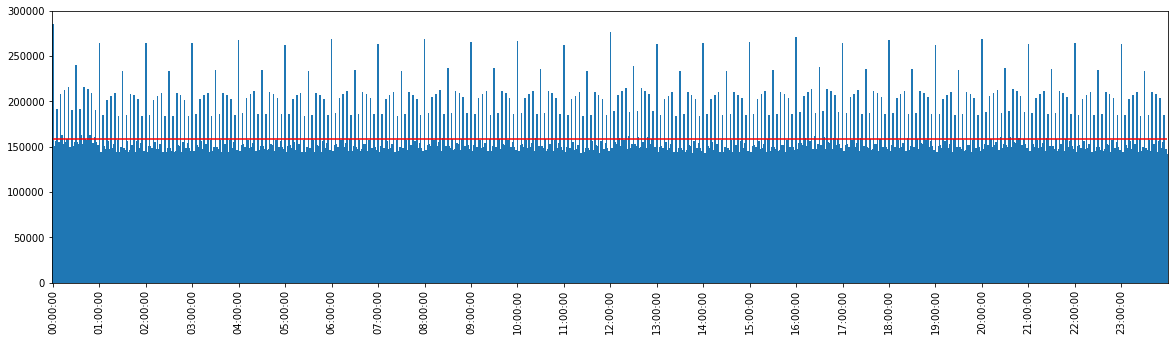

In [244]:
# plot
ipf_totals_plot = ipf_totals_test.copy()

invocations_avg = int(ipf_totals_plot.mean())
invocations_std = int(ipf_totals_plot.std())
p90 = int(ipf_totals_plot.quantile(.9))
p98 = int(ipf_totals_plot.quantile(.98))

plt.figure(figsize=(20,5))
ax = ipf_totals_plot.plot(kind='bar', stacked=True, width=2, x='lab', y='val', rot=90)
new_labels = [row for row in ipf_totals_plot.index]

ax.hlines(invocations_avg, ax.get_xticks().min(), ax.get_xticks().max(), linestyle='-', color='red')

ax.set_xticklabels(new_labels)
ax.set_xticks(ax.get_xticks()[::60])


In [245]:
df_peak = ipf_totals_plot[(ipf_totals_plot >= p98)]
df_sorted = df_peak.sort_values(ascending=False)
df_sorted

00:00:00    285868.0
12:00:00    277048.0
16:00:00    270786.0
06:00:00    269257.0
08:00:00    269056.0
20:00:00    268677.0
18:00:00    268329.0
04:00:00    268318.0
10:00:00    267269.0
15:00:00    265535.0
09:00:00    265307.0
01:00:00    265021.0
14:00:00    264652.0
22:00:00    264644.0
17:00:00    264476.0
03:00:00    264347.0
02:00:00    264127.0
21:00:00    263962.0
07:00:00    263476.0
13:00:00    263404.0
23:00:00    262974.0
05:00:00    262887.0
11:00:00    262666.0
19:00:00    262611.0
00:30:00    240281.0
12:30:00    238948.0
16:30:00    238280.0
20:30:00    237233.0
09:30:00    237052.0
dtype: float64

In [242]:
ipf_totals.to_csv('datasets/ipf_totals.csv', index=True, index_label='timestamp', header=['invocations'])

# App Memory Percentiles

In [ ]:
# dataset de memoria por funcion
amp_data_path = "azurefunctions-dataset2019/app_memory_percentiles.anon.d*.csv"
amp_csv_paths = glob.glob(amp_data_path, recursive=True) # se colocan todos los paths encontrados
amp_dfs = [pd.read_csv(amp_csv_path) for amp_csv_path in amp_csv_paths] # crear un dataframe a partir de cada path
amp_df = pd.concat(amp_dfs) # mergeamos todos estos dataframes en uno solo

In [33]:
display(amp_df)

,HashOwner,HashApp,SampleCount,AverageAllocatedMb,AverageAllocatedMb_pct1,AverageAllocatedMb_pct5,AverageAllocatedMb_pct25,AverageAllocatedMb_pct50,AverageAllocatedMb_pct75,AverageAllocatedMb_pct95,AverageAllocatedMb_pct99,AverageAllocatedMb_pct100
0,432e502f31a50807a4d894301e68a79ff575f3be6521ca...,a4990740c2588808194d784fe0625e3e60f1a588f8ed08...,21379,112,105,106,111,113,116,117,121,125
1,f42d9fe6057c972a789f3eed048b6395ed11278b48109b...,a39f48a85484825ee17ef3c6017a3d0e19fbe033755f8d...,31773,116,99,106,111,115,123,131,139,140
2,43c5a32028b5ea6b2da2533e50f301fca9cf09c25422ad...,777b91f2fc5b28a5408a17bda144bdd0d2e1c749417f60...,18205,123,104,114,119,121,133,134,142,150
3,9c8073e398730c1970a200d071cc00ab1bacee0dc95faa...,b7f4027a889bf944c9f94794d8be6acebc60d32dc86d2f...,19070,183,173,174,182,183,187,187,187,231
4,6b729af68cecdfd09c58680e5b04a7373689f83a8dba07...,07a67894d08c33e0600875702a3c6d1b0fc7359548ee04...,17233,206,203,203,203,208,209,209,209,209
...,...,...,...,...,...,...,...,...,...,...,...,...
17711,500c7f8b5a443aedc56146757a3ca37f400db361fdcac9...,6995776e1330f22f34d1266482ae7e434840469f4ab962...,499,175,153,168,168,173,173,210,217,217
17712,d56bcd7742b1dbfb3d484c4e461670d6676dd8ea30429b...,4b6c3f1db8d6b65d4f81fe3e85233dd5529116cbf422f4...,726,118,104,108,109,116,131,131,134,134
17713,1294343a479d5934bd90b0ab70e8e81e62f9dfad5c11c2...,666b003788148ede2f9652fb144ee92afae6404a7ff122...,267,119,108,115,120,120,121,121,121,121
17714,ca8f87c6114d8b9f5f8ad698c612948e1d6df30e026893...,c8b14b6694c9dbe1863669ce833b9ece198047a20208da...,263,111,92,109,111,111,111,125,125,125


In [34]:
# count no. of unique 
# values in HashApp column
n = amp_df.HashApp.nunique()
  
print("No.of.unique values in HashApp column :",
      n)

No.of.unique values in HashApp column : 23961
